## Body Crop algorithm deployment

In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
from inference import SmartBodyCrop
from PIL import Image
import numpy as np

In [2]:
model_url = "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"
#model_url = "models/optimized_openpose.pb"
inf = SmartBodyCrop(model_url = model_url)

## Download the deep learning (open pose) model

In [3]:
#!mkdir -p models
#!curl -L https://www.dropbox.com/s/2dw1oz9l9hi9avg/optimized_openpose.pb -o models/optimized_openpose.pb

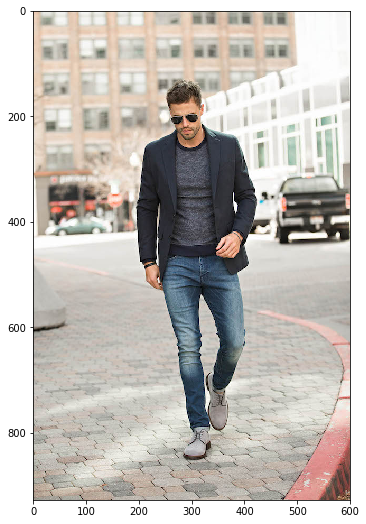

In [4]:
image = Image.open('fashion-men-11.jpg')
image = np.asarray(image)
plt.figure(figsize = (18,9))
plt.imshow(image)
plt.show()

## How algorithm sees the body

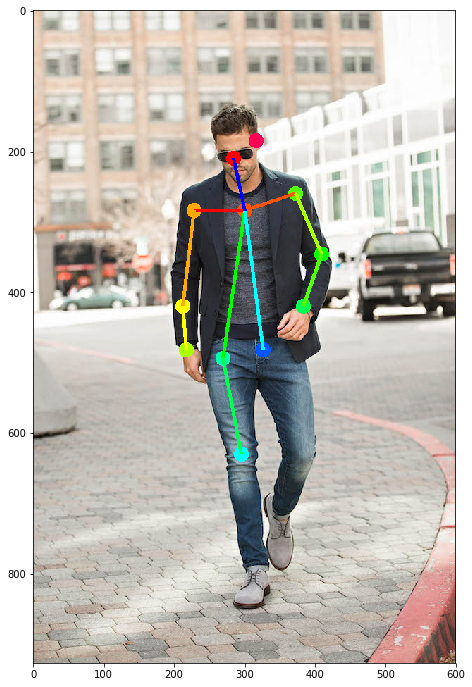

In [5]:
x = inf.detect_parts('fashion-men-11.jpg')
plt.figure(figsize=(24,12))
plt.imshow(x)
plt.show()

## Bodycrop based on detected body parts

image loaded in:      0.0495
Loading the model...
model downloaded in :    47.8144
model imported in :    48.4299
tf session executed in:     59.3003
pose estimated in:      0.0072
image cropped in:      0.0224


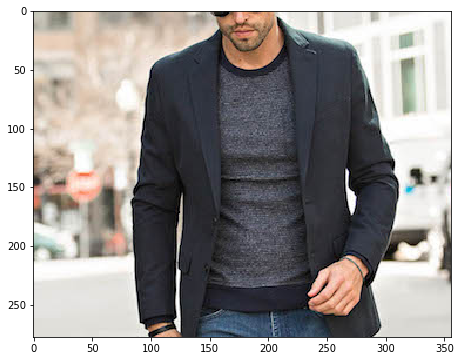

In [6]:
x, coordinates = inf.infer('fashion-men-11.jpg','Nose','Hips')
plt.figure(figsize = (10,6))
plt.imshow(x)
plt.show()

### Draw the crop coordinates on the original image

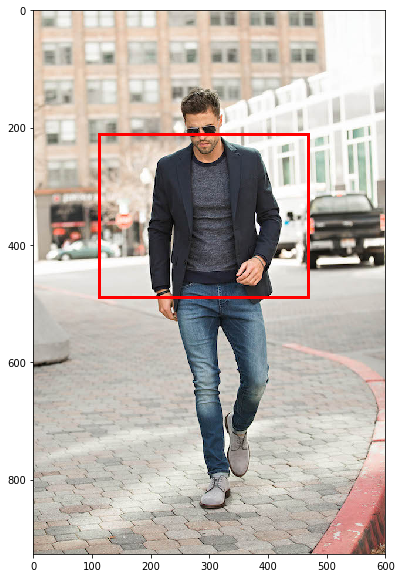

In [7]:
img = Image.open('fashion-men-11.jpg')

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(14,10))
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle(
    (coordinates.get('x'),coordinates.get('y')),
    coordinates.get('width'),coordinates.get('height'),
    linewidth = 3, 
    edgecolor = 'r',
    facecolor = 'none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

## Test with another image too

image loaded in:      0.0447
tf session executed in:      6.8992
pose estimated in:      0.0060
image cropped in:      0.0168
{'y': 36, 'width': 224, 'height': 168, 'x': 58}


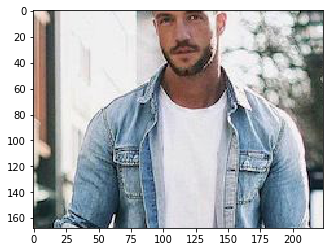

In [8]:
x, coordinates = inf.infer('fashion-men-1.jpg','Eyes','Elbows')
print(coordinates)
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

## Test with a remote image 

image downloaded in :     0.0555
image loaded in:      0.0690
tf session executed in:      3.8458
pose estimated in:      0.0045
image cropped in:      0.0043


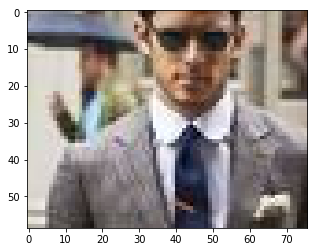

In [9]:
x, coordinates = inf.infer('https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg','Eyes','Elbows')
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

# Deploy the algorithm as a function

### 1. Write the function

In [47]:
%%writefile smart_body_crop.py

from inference import SmartBodyCrop

def action_handler(args):
    model_url = args.get('model_url')
    body_crop = SmartBodyCrop(model_url = model_url)
    print(SmartBodyCrop.initialized)
    print(args)
    crop_img, crop_coordinates = body_crop.infer(args.get('image_url'), 
                    args.get('from_upper'), 
                    args.get('to_lower'))
    return crop_coordinates
    

Overwriting smart_body_crop.py


### Test the function locally

In [12]:
%%time
from smart_body_crop import action_handler
action_response = action_handler({ 
    'model_url': model_url,
    'image_url': 'https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg',
    'from_upper': 'Eyes',
    'to_lower': 'Elbows'})

print(action_response)

True
image downloaded in :     0.0498
image loaded in:      0.0602
tf session executed in:      3.8055
pose estimated in:      0.0049
image cropped in:      0.0057
{'y': 58, 'width': 76, 'height': 59, 'x': 67}
CPU times: user 7.21 s, sys: 1.37 s, total: 8.58 s
Wall time: 3.94 s


### 2. Configure Apache OpenWhisk as the FaaS Provider to deploy the function

In [13]:
%%bash
which wsk && exit
echo "Installing wsk CLI ..."
curl -L https://github.com/apache/incubator-openwhisk-cli/releases/download/latest/OpenWhisk_CLI-latest-linux-amd64.tgz -o /tmp/wsk.tgz 
tar xvfz /tmp/wsk.tgz -C /tmp/
mv /tmp/wsk /usr/local/bin

/usr/local/bin/wsk


#### Configure Apache OpenWhisk credentials


In [14]:
%%writefile ~/.wskprops
AUTH=--CHANGE--ME
APIHOST=runtime.adobe.io

Overwriting /root/.wskprops


### 3. Deploy the function

The function must ZIP the other dependent python scripts used to train the model. The action code must be places in a file called `__main__.py`.

In [48]:
%%bash
mkdir -p action_package

cp smart_body_crop.py action_package/__main__.py
cp *.py action_package/
cd action_package && zip -9 -r ../action.zip ./

updating: smart_body_crop.py (deflated 52%)
updating: common.py (deflated 68%)
updating: inference.py (deflated 73%)
updating: __main__.py (deflated 52%)


In [49]:
model_url = "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"

In [50]:
%%bash -s "$model_url"

wsk action update smart_body_crop action.zip --main action_handler  \
    --param model_url "$1" \
    --param from_upper Eyes \
    --param to_lower Elbows \
    --memory 3891 \
    --docker ddragosd/openwhisk-python3aiaction

ok: updated action smart_body_crop


In [51]:
!wsk action get smart_body_crop

ok: got action smart_body_crop
{
    "namespace": "ddascal",
    "name": "smart_body_crop",
    "version": "0.0.5",
    "exec": {
        "kind": "blackbox",
        "image": "ddragosd/openwhisk-python3aiaction",
        "main": "action_handler",
        "binary": true
    },
    "annotations": [
        {
            "key": "exec",
            "value": "blackbox"
        }
    ],
    "parameters": [
        {
            "key": "model_url",
            "value": "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"
        },
        {
            "key": "from_upper",
            "value": "Eyes"
        },
        {
            "key": "to_lower",
            "value": "Elbows"
        }
    ],
    "limits": {
        "timeout": 60000,
        "memory": 3891,
        "logs": 10
    },
    "publish": false
}


In [55]:
!wsk action invoke smart_body_crop --param image_url "https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg" \
  --param from_upper Eyes --param to_lower Elbows

ok: invoked /_/smart_body_crop with id d5c1883a4ce547bd81883a4ce5b7bd89


### Note on first run 
On initial run the function has to:
* (potentially) pull the docker image
* download the model

These steps will take a few seconds.

In [56]:
!wsk activation get d5c1883a4ce547bd81883a4ce5b7bd89

ok: got activation d5c1883a4ce547bd81883a4ce5b7bd89
{
    "namespace": "ddascal",
    "name": "smart_body_crop",
    "version": "0.0.5",
    "subject": "ddascal",
    "activationId": "d5c1883a4ce547bd81883a4ce5b7bd89",
    "start": 1540948411806,
    "end": 1540948413399,
    "duration": 1593,
    "response": {
        "status": "success",
        "statusCode": 0,
        "success": true,
        "result": {
            "height": 59,
            "width": 76,
            "x": 67,
            "y": 58
        }
    },
    "logs": [
        "2018-10-31T01:13:31.809978895Z stdout: True",
        "2018-10-31T01:13:31.809998423Z stdout: {'model_url': 'https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb', 'image_url': 'https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg', 'from_upper': 'Eyes', 'to_lower': 'Elbows'}",
        "2018-10-31T01:13:31.902160039Z stdout: image downloaded in :     0.0922",
        "2018-1

(600, 400, 3)
(400, 3)
(400, 600, 3)


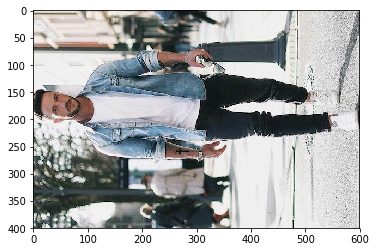

In [11]:
img1 = Image.open('fashion-men-1.jpg')
img1 = np.asarray(img1)
print(img1.shape)
print(img1[0].shape)
img_transpose = img1.transpose(1, 0, 2)
print(img_transpose.shape)

plt.figure(figsize = (8,4))
plt.imshow(img_transpose)
plt.show()